In [5]:
# gen wf

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16}) 

In [7]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [8]:
import numpy as np

In [13]:
import os

In [15]:
import h5py

In [9]:
# Setup enviroment to autoreload packages
%load_ext autoreload
%autoreload 2
# Turn on inline plotting with matplotlib, and import needed thigs from nrutils
%matplotlib inline
# Let's only import the catalog search function, and the loading function
from nrutils import scsearch,gwylm

(positive)>> Applying custom matplotlib settings.


In [10]:
from nrutils.core.nrsc import *

## Find a simulation(s) using scsearch

In [11]:
help(scsearch)

Help on function scsearch in module nrutils.core.nrsc:

scsearch(catalog=None, q=None, nonspinning=None, spinaligned=None, spinantialigned=None, precessing=None, nonprecessing=None, equalspin=None, unequalspin=None, antialigned=None, setname=None, notsetname=None, institute=None, keyword=None, notkeyword=None, unique=None, plot=None, exists=None, validate_remnant=None, apply_remnant_fit=None, verbose=None)
    # Function for searching through catalog files.



In [12]:
# Search for simulations
# A = scsearch(q=[3.9,8.1], institute='bam', verbose=True)
A = scsearch(institute='bam', verbose=True, precessing=True)

(scsearch)>> Found institute (=bam) keyword.
(scsearch)>> Found precessing (=True) keyword.
(scsearch)>> Found verbose (=True) keyword.
## Found 40 possibly degenerate simulations:
[0001][hogshead] NR_data: 1chi0.80-p-q8.00	(q8a08t90dP0_T_96_384)
[0002][hogshead] NR_data: 1chi0.80-p-q8.00	(q8a08t60Ditm45dr075_96_360)
[0003][hogshead] NR_data: 1chi0.80-p-q8.00	(q8a08t30dPm9.35_r0.5_T_96_360)
[0004][hogshead] NR_data: 1chi0.80-p-q8.00	(q8a08t150dP2_T_96_360)
[0005][hogshead] NR_data: 1chi0.40-p-q8.00	(q8a04t90dP0_T_96_360)
[0006][hogshead] NR_data: 1chi0.40-p-q8.00	(q8a04t90_T_96_360)
[0007][hogshead] NR_data: 1chi0.40-p-q8.00	(q8a04t60_T_96_360)
[0008][hogshead] NR_data: 1chi0.40-p-q8.00	(q8a04t60D_dPm1)
[0009][hogshead] NR_data: 1chi0.40-p-q8.00	(q8a04t30dPm3_T_96_360)
[0010][hogshead] NR_data: 1chi0.40-p-q8.00	(q8a04t30_T_96_360)
[0011][hogshead] NR_data: 1chi0.40-p-q8.00	(q8a04t150dP9_T_96_360)
[0012][hogshead] NR_data: 1chi0.40-p-q8.00	(q8a04t120dPp1_T_96_360)
[0013][hogshead] NR_da

In [39]:
def get_peak_time(t, amp):
    peak_index = np.argmax(amp)
    peak_time = t[peak_index]
    return peak_time

In [40]:
def resample(x, y, newx):
    return IUS(x, y)(newx)

In [41]:
def compute_sym_waveform(h2m2, h22):
    hplus = (h22 + np.conj(h2m2))/2
    hminus = (h22 - np.conj(h2m2))/2
    return hplus, hminus

In [42]:
def compute_amp(complex_data):
    return np.abs(complex_data)

def compute_phase(complex_data):
    return np.unwrap(np.angle(complex_data))

def compute_dphase(complex_data, time):
    phase = compute_phase(complex_data)
    iphase = IUS(time, phase)
    return iphase.derivative()(time)

In [53]:
def resample_complex(times, complex_data, new_times):
    amp = compute_amp(complex_data)
    phase = compute_phase(complex_data)
    
    new_amp = resample(times, amp, new_times)
    new_phase = resample(times, phase, new_times)
    
    new_complex_data = new_amp * np.exp(1.j * new_phase)
    return new_complex_data

In [43]:
def get_co_prec_sym_waveform(ylm, kind='psi4', t1=None, t2=None, npts=5000):
    
    print("ylm simname {}".format(ylm.simname))
    
    print("kind: {}".format(kind))
    
    print("calc initial j frame")
    ylm_coprec = ylm.__calc_initial_j_frame__()
    
    print("calc coprecessing frame")
    ylm_coprec = ylm_coprec.__calc_coprecessing_frame__()
    
    t0_coprec = get_peak_time(ylm_coprec.radiation_axis_info.gwylmo[2,2][kind].t, ylm_coprec.radiation_axis_info.gwylmo[2,2][kind].amp)
    
    t_coprec_shift = ylm_coprec.radiation_axis_info.gwylmo[2,2][kind].t - t0_coprec
    
    if t1 is None:
        t1 = t_coprec_shift[0]
    if t2 is None:
        t2 = t_coprec_shift[-1]
    
    print("t1 = {}".format(t1))
    print("t2 = {}".format(t2))
    
    
    print("computing symmetrised waveform")
    print("**should check sign convention here I use +1.j")
    h2m2_tmp = ylm_coprec[2,-2][kind].wfarr[:,1] + 1.j * ylm_coprec[2,-2][kind].wfarr[:,2]
    h22_tmp = ylm_coprec[2,2][kind].wfarr[:,1] + 1.j * ylm_coprec[2,2][kind].wfarr[:,2]
    
    h22_plus, h22_minus = compute_sym_waveform(h2m2_tmp, h22_tmp)
    print("working with h22_plus")
    
    amp = compute_amp(h22_plus)
    phase = compute_phase(h22_plus)
    dphase = compute_dphase(h22_plus, t_coprec_shift)
    
    newt = np.linspace(t1, t2, npts)

    print("resampling")
    coprec_sym_data = {}
    coprec_sym_data.update({
        't':newt,
        'amp':resample(t_coprec_shift, amp, newt),
        'phi':resample(t_coprec_shift, phase, newt),
        'dphi':resample(t_coprec_shift, dphase, newt),
        'simname':ylm_coprec.simname
    })
    print("**should check sign convention here I use +1.j")
    coprec_sym_data.update({"h22":coprec_sym_data["amp"]*np.exp(1.j*coprec_sym_data["phi"])})
    
    print("done")
    return coprec_sym_data

In [48]:
def my_makedir(path):
    if not os.path.isdir(path):
        os.mkdir(path)
        print("Successfully created the directory '{}' ".format(path))
    else:
        print("directory '{}' already exists".format(path))

In [170]:
def save_data(screnty_ob, output_dir, lmax, gwylm_verbose, verbose, npts):
    if verbose:
        print("\n")
        print(">>>")
        print(">>> working simname: {}".format(obj.simname))
        print(">>>")
        print("\n")
    output_filename = os.path.join(output_dir, "{}.h5".format(obj.simname))
    
    if verbose:
        print("getting gwylm")
    ylm = gwylm( scentry_obj = obj, lmax=lmax, verbose=gwylm_verbose )
    
    coprec_sym_dict = {}
    if verbose:
        print("getting coprec and sym waveform [psi4]")
    coprec_sym_dict['psi4'] = get_co_prec_sym_waveform(ylm, kind='psi4')
    if verbose:
        print("getting coprec and sym waveform [strain]")
    coprec_sym_dict['strain'] = get_co_prec_sym_waveform(ylm, kind='strain')
    
    # the times from psi4 and strain or not the same so we should
    # resample to common times
    print("*****")
    print([coprec_sym_dict['psi4']['t'][0], coprec_sym_dict['strain']['t'][0]])
    print([coprec_sym_dict['psi4']['t'][-1], coprec_sym_dict['strain']['t'][-1]])
    print("*****")
    common_t1 = np.max([coprec_sym_dict['psi4']['t'][0], coprec_sym_dict['strain']['t'][0]])
    common_t2 = np.min([coprec_sym_dict['psi4']['t'][-1], coprec_sym_dict['strain']['t'][-1]])
    print("common_t1: {}".format(common_t1))
    print("common_t2: {}".format(common_t2))

    if verbose:
        print("resampling psi4 and strain to a common time grid")
    new_times = np.linspace(common_t1, common_t2, npts)
    psi4_data = resample_complex(coprec_sym_dict['psi4']['t'], coprec_sym_dict['psi4']['h22'], new_times)
    strain_data = resample_complex(coprec_sym_dict['psi4']['t'], coprec_sym_dict['strain']['h22'], new_times)
    
    if verbose:
        print("making file: {}".format(output_filename))
    with h5py.File(output_filename, "w") as f:
        f.attrs['simname'] = obj.simname
        f.attrs['X1'] = obj.X1
        f.attrs['X2'] = obj.X2
        f.attrs['eta'] = obj.eta
        
        f.create_dataset("times", data=new_times)
        f.create_dataset("psi4", data=psi4_data)
        f.create_dataset("strain", data=strain_data)

In [171]:
A[:2]

[<nrutils.core.nrsc.scentry instance at 0x2b2a2be4ec68>,
 <nrutils.core.nrsc.scentry instance at 0x2b2a2c1a7710>]

In [172]:
%%time
lmax=2
gwylm_verbose=False
verbose=True
output_dir='data'
npts=5000
my_makedir(output_dir)
for obj in A:
    save_data(screnty_ob=obj, output_dir=output_dir, lmax=lmax, gwylm_verbose=gwylm_verbose, verbose=verbose, npts=npts)

directory data already exists


>>>
>>> working simname: q8a08t90dP0_T_96_384
>>>


getting gwylm

# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(load_dynamics)>> Trying to load source dynamics ...
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(load_dynamics)>> Calculating dynamics times by adjusting input waveform_times by extraction radius
(load_dynamics)>> Retrieving method from handler for loading source dyanmics as this is specific to BAM, GT-MAYA, SXS, etc ...
(load_dynamics)>> Loading/Learning dynamics ...
(load_dynamics)>> Done.
getting coprec and sym waveform [psi4]
ylm simname q8a08t90dP0_T_96_384
kind: psi4
calc initial j frame
(__rotate_frame_at_all_times__)>> Attempting to rotate dynamics timeseries in this.dynamics
(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) have not been rotated, but this.Sf, this.R1 and others have been rotated. This includes radiated and remnant quantities.

In [177]:
def read_data(filename):
    with h5py.File(filename, 'r') as f:
        print(f.keys())
        print(f.attrs.keys())
        print(f['times'])
        
        fig, axes = plt.subplots(1, 2, figsize=(14,5))
        axes[0].plot(f['times'], np.real(f['psi4']))
        axes[1].plot(f['times'], np.real(f['strain']))
        axes[0].set_xlim(-100,100)
        axes[1].set_xlim(-100,100)
  
        psi4_phi = compute_phase(f['psi4'])
        strain_phi = compute_phase(f['strain'])
        
        fig, axes = plt.subplots(1, 2, figsize=(14,5))
        axes[0].plot(f['times'], psi4_phi)
        axes[1].plot(f['times'], strain_phi)
#         axes[0].set_xlim(-100,100)
#         axes[1].set_xlim(-100,100)


        psi4_dphi = compute_dphase(f['psi4'], f['times'])
        strain_dphi = compute_dphase(f['strain'], f['times'])
        
        fig, axes = plt.subplots(1, 2, figsize=(14,5))
        axes[0].plot(f['times'], psi4_dphi)
        axes[1].plot(f['times'], strain_dphi)
#         axes[0].set_xlim(-100,100)
#         axes[1].set_xlim(-100,100)
        return f['times'][:], f['psi4'][:]

[u'psi4', u'strain', u'times']
[u'X1', u'X2', u'eta', u'simname']
<HDF5 dataset "times": shape (5000,), type "<f8">


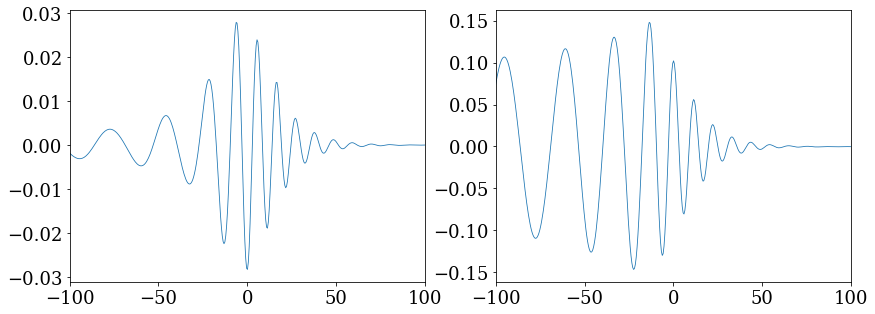

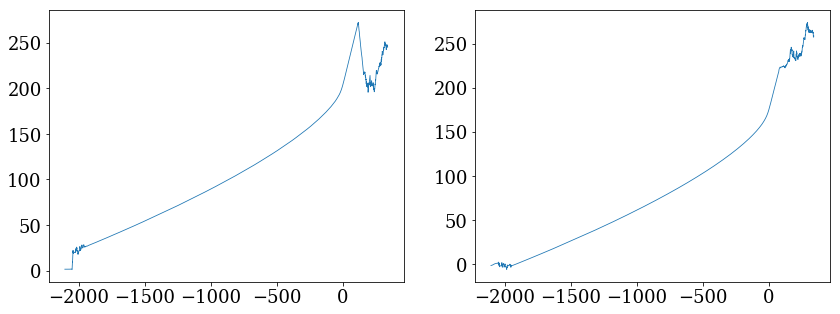

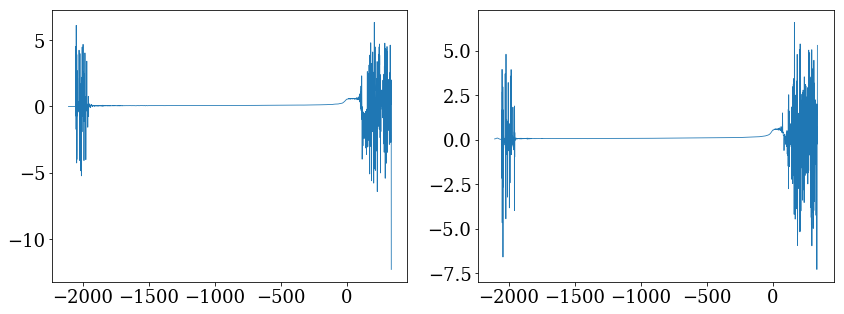

In [178]:
t, psi4 = read_data('data/q8a08t60Ditm45dr075_96_360.h5')